# 3. Clasificación

**Alumno:** Aguilera Luzania José Luis

## Contenido
---

**Introducción**
- ¿Qué es la detección de noticias falsas? (*Fake news*).
- Objetivo de la libreta.

**Procesamiento de los datos**
- Librerías
- Cargar el *corpus*
- Datos necesarios: *Text* y *Category*
- Palabras vacías o *stopwords*
- *Snowball Stemmer*
- Procesamiento del texto
- Vectorización y características TFIDF
- Separación de los conjuntos de datos

**Métricas**
- Matriz de confusión

**Naive Bayes Multinomial**
- Modelo
- Resultados

**Regresión Logística**
- Modelo
- Resultados

**Red LSTM (Long Short-Term Memory)**
- Procesar los datos
- Tokenizar los datos
- Cargar embeddings de palabras en español
- Conjunto de entrenamiento y de pruebas
- Modelo
- Entrenamiento
- Resultados

## Introducción
---

#### Clasificación de texto

La clasificación de textos es la tarea de clasificar un documento en una categoría predefinida, es decir, si *d_j* es un documento del conjunto de documentos *D* y *{c_1, c_2, ..., c_n}* es el conjunto de categorías, entonces la clasificación de textos asigna una categoría *c_i* al documento *d_j*. El caso de la detección de noticias falsas se puede resolver como un problema de clasificación de textos, donde a cada noticia *n_i* del conjunto de noticias *N* le asignamos una categoría del conjunto *{true, fake}*.

El proceso de clasificación de textos se muestra en la siguiente figura:

<img src="Imagenes\proceso_clasificacion_textos.png" width="500">

#### Objetivo de la libreta

El objetivo de esta libreta es mostrar el procesamiento necesario del texto para después ser usado en un clasificador de texto y utilizar distintos métodos para clasificar el texto.

## Procesamiento de los datos
---

#### Librerías

Manipulación de datos:
- `pandas`: Librería para manipular los datos de forma tabular.
- `numpy`: Librería para la manipulación de datos de forma numérica, vectorial.
- `re`: Librería para el uso de expresiones regulares.
- `cmd`: Librería para controlar el formato de impresión en la consola.

Procesamiento del lenguaje natural:
- `nltk`: Librería para utilizar técnicas de procesamiento del lenguaje natural.

Presentación de los datos:
- `matplotlib`: Librería para graficar.
- `seaborn`: Librería auxiliar para graficar.
- `wordcloud`: Librería para generar una nube de palabras y guardarla como imagen *.png*.

Inteligencia Artificial
- `sklearn`: Librería de herramientas para el procesamiento de los datos y creación de modelos para la clasificación del texto.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from tqdm.notebook import tqdm_notebook

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dropout, Dense, Embedding, Bidirectional
from keras import Sequential

#### Datos adicionales para la librería `nltk`

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JoseLuisAL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JoseLuisAL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Cargar el corpus

In [3]:
corpus = pd.read_csv('Datos/corpus_spanish_v3.csv', encoding='utf-8', index_col=0)
corpus.head()

,Category,Topic,Source,Headline,Text,Link
0,True,Science,El país,La NASA recupera el contacto con un satélite d...,La NASA recupera el contacto con un satélite d...,https://elpais.com/elpais/2018/02/01/ciencia/1...
1,True,Economy,El financiero,AMLO aceleraría el consumo y el crecimiento ec...,AMLO aceleraría el consumo y el crecimiento ec...,http://www.elfinanciero.com.mx/economia/amlo-a...
2,Fake,Sport,actualidadpanamericana.com,Compañero de James se ‘calvea’ y le juega pesa...,Al borde de un colapso nervioso quedó el hábil...,http://www.actualidadpanamericana.com/companer...
3,Fake,Politics,actualidadpanamericana.com,Dian gravará este año a los niños que recojan ...,"Mediante pupitrazo de último minuto anoche, el...",http://www.actualidadpanamericana.com/dian-gra...
4,Fake,Politics,actualidadpanamericana.com,Uribe asegura que insultó 358 guerrilleros,Muy temprano esta mañana el expresidente y aho...,http://www.actualidadpanamericana.com/uribe-as...


#### Palabras vacías o *stopwords*

Las *stopwords* o palabras vacías son aquellas que carecen de sentido de manera individual o sin una palabra clave o *keyword*. Se utilizan las *stopwords* proporcionadas por la librería `nltk` en conjunto con las obtenidas del repositorio "stopwords-es" del usuario [genediazjr](https://github.com/stopwords-iso/stopwords-es).

In [4]:
stopwords_spanish_nltk = stopwords.words('spanish')
stopwords_spanish_json = list(pd.read_json('Datos/stopwords-es.json')[0])

stopwords_spanish = list(set(stopwords_spanish_nltk+stopwords_spanish_json))

#### *Snowball Stemmer*



In [5]:
snowball_stemmer = SnowballStemmer('spanish')

#### Procesamiento del texto

In [6]:
def process_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"http", "", text)
    text = re.sub("\n", " ", text)
    text = text.replace(r"*NUMBER*", "número")
    text = text.replace(r"*PHONE*", "número")
    text = text.replace(r"*EMAIL*", "email")
    text = text.replace(r"*URL*", "url")
    text = re.sub('[^ A-Za-z\dÁÉÍÓÚÑáéíóúñ/]+', ' ', text)
    text = text.lower()
    text = text.split()
    text = [snowball_stemmer.stem(word) for word in text if not word in stopwords_spanish]
    text = ' '.join(text)

    return text

# Separar los datos a utilizar
X = corpus['Text']
y = corpus['Category']

y = y.astype("category").cat.codes

# Procesar los textos
tqdm_notebook.pandas(desc="Procesando el texto")
X = X.progress_apply(process_text)

# Convertir los conjuntos a un numpy ndarray
X = X.values
y = y.values

Procesando el texto:   0%|          | 0/3974 [00:00<?, ?it/s]

#### Vectorización y características TFIDF

In [7]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(X).toarray()

#### Separación de los conjuntos de datos

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2021)

## Métricas
---

#### Matriz de confusión

In [9]:
def plot_confusion_matrix(y_test_values, y_predicted_values, method=''):
    cf_matrix = confusion_matrix(y_test_values, y_predicted_values)
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    fig, ax = plt.subplots(figsize = (7, 5.5))
    sns.heatmap(cf_matrix, annot = labels, ax = ax, fmt = '',cmap = 'Blues', annot_kws = {"size": 13})

    # Etiquetas, título y ticks
    label_font = {'size':'15'}
    ax.set_xlabel(' \nPredicción', fontdict = label_font)
    ax.set_ylabel('Valores reales\n', fontdict = label_font)

    title_font = {'size':'16'}
    cf_matrix_title = 'Matriz de confusión: ' + method + '\n'
    ax.set_title(cf_matrix_title, fontdict = title_font)

    ax.tick_params(axis = 'both', which = 'major', labelsize = 13)
    ax.xaxis.set_ticklabels(['Fake', 'Real'])
    ax.yaxis.set_ticklabels(['Fake', 'Real'])
    plt.show()

## Naive Bayes Multinomial
---


#### Introducción
El método blah, blah, blah, blah, blah

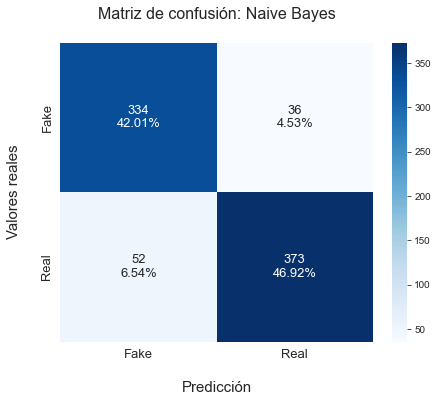

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       386
           1       0.88      0.91      0.89       409

    accuracy                           0.89       795
   macro avg       0.89      0.89      0.89       795
weighted avg       0.89      0.89      0.89       795



In [10]:
# Modelo ════════════════════════════════════════════════════
model_NB = MultinomialNB(alpha=0.5)
model_NB.fit(X_train, y_train)

# Predicción ════════════════════════════════════════════════
y_predicted_NB = model_NB.predict(X_test)

# Resultados ════════════════════════════════════════════════
# Matriz de confusión
plot_confusion_matrix(y_predicted_NB, y_test, 'Naive Bayes')

# Reporte de clasificación
print(classification_report(y_test, y_predicted_NB))

## Regresión Logística
---

#### Introducción

El método blah, blah, blah, blah, blah

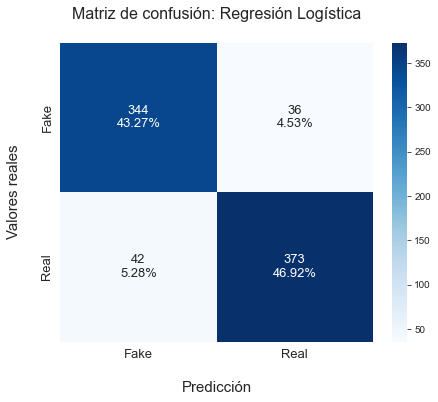

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       386
           1       0.90      0.91      0.91       409

    accuracy                           0.90       795
   macro avg       0.90      0.90      0.90       795
weighted avg       0.90      0.90      0.90       795



In [11]:
# Modelo ════════════════════════════════════════════════════
model_LR = LogisticRegression(max_iter=2000)
model_LR.fit(X_train, y_train)

# Predicción ════════════════════════════════════════════════
y_predicted_LR = model_LR.predict(X_test)

# Resultados ════════════════════════════════════════════════
# Matriz de confusión
plot_confusion_matrix(y_predicted_LR, y_test, 'Regresión Logística')

# Reporte de clasificación
print(classification_report(y_test, y_predicted_LR))


## Red LSTM (Long Short-Term Memory)
---

#### Introducción

blah, blah, blah, blah...

### Procesar los datos

In [12]:
# Datos necesarios ══════════════════════════════════════════
X_LSTM = corpus['Text']
y_LSTM = corpus['Category']

y_LSTM = y_LSTM.astype("category").cat.codes

# Procesamiento del texto ═══════════════════════════════════
tqdm_notebook.pandas(desc="Procesando el texto")
X_LSTM = X_LSTM.progress_apply(process_text)

# Convertir datos en vectores ═══════════════════════════════
X_LSTM = X_LSTM.values
y_LSTM = y_LSTM.values

Procesando el texto:   0%|          | 0/3974 [00:00<?, ?it/s]

### Tokenizar los datos

In [13]:
# Tokenizador ═══════════════════════════════════════════════
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_LSTM)

# Vocabulario ═══════════════════════════════════════════════
word_index = tokenizer.word_index
vocab_size = len(word_index)
print(f'Vocab size: {vocab_size}')

# Secuencias ════════════════════════════════════════════════
sequences = tokenizer.texts_to_sequences(X_LSTM)
padded_seq = pad_sequences(sequences, maxlen=300, padding='post', truncating='post')

Vocab size: 37431


#### Cargar embeddings de palabras en español

In [14]:
word_embeddings_spanish_path = 'Datos/SBW-vectors-300-min5.txt'

# Cargar los embeddings ═════════════════════════════════════
embedding_index = {}
with open(word_embeddings_spanish_path, 'r', encoding="utf8") as file:
    file.readline()
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Matriz de embeddings ══════════════════════════════════════
embedding_matrix = np.zeros((vocab_size+1, 300))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#### Conjunto de entrenamiento y de pruebas

In [15]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(padded_seq, y_LSTM, test_size=0.2, stratify=y_LSTM, random_state=2021)

#### Modelo

In [16]:
# Modelo ════════════════════════════════════════════════════
model_LSTM = Sequential([
    Embedding(vocab_size+1, 300, weights=[embedding_matrix], mask_zero=True, trainable=True),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Información del modelo ════════════════════════════════════
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         11229600  
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

#### Entrenamiento

In [17]:
history = model_LSTM.fit(X_train_lstm,
                         y_train_lstm,
                         epochs=10,
                         batch_size=16,
                         validation_data=(X_test_lstm, y_test_lstm),
                         verbose=1)

Epoch 1/10
199/199 [==============================] - 39s 102ms/step - loss: 0.3194 - acc: 0.8380 - val_loss: 0.1859 - val_acc: 0.8981
Epoch 2/10
199/199 [==============================] - 16s 79ms/step - loss: 0.0690 - acc: 0.9767 - val_loss: 0.2274 - val_acc: 0.8981
Epoch 3/10
199/199 [==============================] - 17s 83ms/step - loss: 0.0075 - acc: 0.9984 - val_loss: 0.2869 - val_acc: 0.9107
Epoch 4/10
199/199 [==============================] - 16s 82ms/step - loss: 9.7649e-04 - acc: 1.0000 - val_loss: 0.3257 - val_acc: 0.9094
Epoch 5/10
199/199 [==============================] - 16s 83ms/step - loss: 3.6335e-04 - acc: 1.0000 - val_loss: 0.3482 - val_acc: 0.9107
Epoch 6/10
199/199 [==============================] - 17s 85ms/step - loss: 1.3265e-04 - acc: 1.0000 - val_loss: 0.3676 - val_acc: 0.9082
Epoch 7/10
199/199 [==============================] - 17s 85ms/step - loss: 8.1488e-05 - acc: 1.0000 - val_loss: 0.3823 - val_acc: 0.9107
Epoch 8/10
199/199 [=========================

#### Resultados

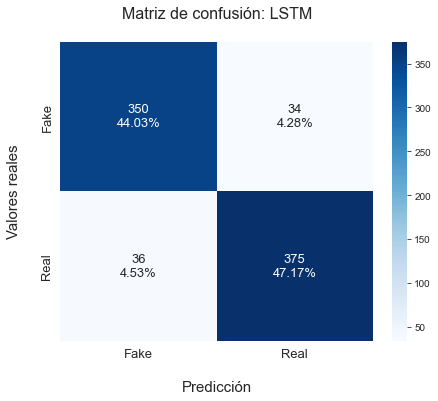

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       386
           1       0.91      0.92      0.91       409

    accuracy                           0.91       795
   macro avg       0.91      0.91      0.91       795
weighted avg       0.91      0.91      0.91       795



In [18]:
# Predicción ════════════════════════════════════════════════
y_predicted_LSTM = (model_LSTM.predict(X_test_lstm) >= 0.5).astype(int)

# Resultados ════════════════════════════════════════════════
# Matriz de confusión
plot_confusion_matrix(y_predicted_LSTM, y_test_lstm, 'LSTM')

# Reporte de clasificación
print(classification_report(y_test_lstm, y_predicted_LSTM))